In [1]:
import numpy as np
import pandas as pd
import datetime
import pickle
import os
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.ensemble import RandomForestClassifier

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.calibration import CalibratedClassifierCV
from nltk.corpus import stopwords
import matplotlib.pyplot as plt

In [2]:
## ADDITIONAL FUNCTIONS
if not os.path.exists('models'):
    os.makedirs('models')

pStopWordsList = stopwords.words('english') + stopwords.words('russian')
    
def process_text_layer(TextLayer, pStopWordsList = []):
    txt =  " ".join([w for w in TextLayer.lower().split() \
                     if (not w in pStopWordsList)])

    txt = txt. \
        replace('«', ''). \
        replace('»', ''). \
        replace('(', ''). \
        replace(')', ''). \
        replace('\[)', ''). \
        replace('\]', ''). \
        replace('^', ''). \
        replace('\\', '')

    return txt

def learnBinaryClassifier(ds):
    '''Kлассификатор. 
   Input: ds (dataframe): x - текстовый слой; target - результат
   Output: CountVectorizer, RandomForestClassifier
   '''
    ngram_range = (1, 3)
    max_features = 50000
    n_estimators=100

    print("Create vectorizer")
    vectorizer = CountVectorizer(analyzer = "word",
                                tokenizer = None,
                                preprocessor = None,
                                stop_words = None, 
                                ngram_range = ngram_range,
                                max_features = max_features
                                )

    print("Fit and Transform vectorizer")

    X_train = ds['x']
    Y_train = ds['target']

    X_train = vectorizer.fit_transform(X_train)
    X_train = X_train.toarray()

    model = RandomForestClassifier(n_estimators=n_estimators)

    print("Fit Model")
    model = model.fit(X_train, Y_train)

    return vectorizer, model

In [3]:
def learnBinaryClassifier_CountVectorizer(ds):
    '''Kлассификатор. 
   Input: ds (dataframe): x - текстовый слой; target - результат
   Output: CountVectorizer, RandomForestClassifier
   '''
    ngram_range = (1, 3)
    max_features = 50000
    n_estimators=100

    print("Create vectorizer")
    vectorizer = CountVectorizer(analyzer = "word",
                                tokenizer = None,
                                preprocessor = None,
                                stop_words = None, 
                                ngram_range = ngram_range,
                                max_features = max_features
                                )

    print("Fit and Transform vectorizer")

    X_train = ds['x']
    Y_train = ds['target']

    X_train = vectorizer.fit_transform(X_train)
    X_train = X_train.toarray()

    model = RandomForestClassifier(n_estimators=n_estimators)

    print("Fit Model")
    model = model.fit(X_train, Y_train)

    return vectorizer, model
def learnBinaryClassifier_TF_IDF(ds, weight = 300):
    '''Kлассификатор. 
   Input: ds (dataframe): x - текстовый слой; target - результат
   Output: CountVectorizer, RandomForestClassifier
   '''
    ngram_range = (1, 3)
    max_features = 50000
    n_estimators=100

    print("Create vectorizer")
    vectorizer = TfidfVectorizer(analyzer = "word",
                                tokenizer = None,
                                preprocessor = None,
                                stop_words = None, 
                                ngram_range = ngram_range,
                                max_features = max_features
                                )

    print("Fit and Transform vectorizer")

    X_train = ds['x']
    Y_train = ds['target']

    X_train = vectorizer.fit_transform(X_train)
    X_train = X_train.toarray()

    model = RandomForestClassifier(n_estimators=n_estimators,class_weight={0:1,1:weight})
    model = CalibratedClassifierCV(base_estimator=model, cv=3)
    print("Fit Model")
    try:
        model = model.fit(X_train, Y_train)
    except:
        print("No 1")
    return vectorizer, model


In [4]:
text_data = pd.read_csv('CLASS PROSPECTUS.csv')
text_data['string_value'] = text_data['string_value'].astype(str)
class_data = pd.read_excel('CLASS PROSPECTUS.xlsx', sheet_name = 'DATA')

models_rename = {
    "Ограничение по предоставлению залога":"Restriction_on_the_provision_of_collateral",
    "Изменение контроля":"Change_of_control",
    "Случаи дефолта":"Cases_of_default",
    "Кросс-дефолт":"Cross-default",
    "Оговорки о коллективных действиях":"Collective_action_clauses",
    "Ограничение задолженности":"Limitation_on_indebtedness",
    "Ограничение задолженности дочерних компаний":"Limitation_of_debt_of_subsidiaries",
    "Ограничение по платежам":"Limitation_on_payments",
    "Ограничение по инвестициям":"Investment_restriction",
    "Ограничение по платежам в отношении дочерних компаний":"Limitation_on_payments_to_subsidiaries",
    "Ограничение по транзакциям с аффилированными лицами":"Restriction_on_transactions_with_affiliates",
    "Ограничение деятельности":"Restriction_of_activity",
    "Ограничение по продаже активов":"Restriction_on_asset_sales",
    "Ограничение по продаже активов с обратной арендой":"Restriction_on_the_sale_of_assets_with_leaseback",
    "Ограничение по слиянию":"Limitation_on_merger",
    "Триггер рейтингов":"Ratings_trigger",
    "Обозначение прав дочерних компаний (restricted / unrestricted)":"Designation_of_the_rights_of_subsidiaries",
    "Ограничение по наслоению долговых обязательств по рангам":"Restriction_on_the_layering_of_debt_obligations_by_rank",
    "Условие приостановки действия ковенантов":"A_condition_of_suspension_of_the_covenants",
    "Финансовые ковенанты":"Financial_covenants"}
class_data = class_data.rename(columns=models_rename)

In [6]:
# Уменьшаем размерность задачи, так как слишком много нулевых данных
tags = list(class_data['tag'])
new_tags = list(text_data[~text_data['tag'].isin(tags)].sample(3000)['tag'])
new_tags = new_tags + tags
text_data = text_data[text_data['tag'].isin(new_tags)]

In [7]:
data = text_data.merge(class_data, on='tag', how='left').copy()
data['string_value'] = data.apply(lambda r: process_text_layer(r['string_value'], pStopWordsList), axis = 1)
models = list(data.columns)[2:]

In [8]:
# По ковенанте ratings_trigger и Обозначение прав нет ни одного документа, её содержащего, так что вырежем её из списка моделей
if "Ratings_trigger" in models:
    models.remove("Ratings_trigger")
if "Обозначение прав дочерних компаний (restricted unrestricted)" in models:
    models.remove("Обозначение прав дочерних компаний (restricted unrestricted)")


In [9]:
datasets = {}
#models = ['Change_of_control']
for model_name in models:
    ds = data[['tag','string_value', model_name]].rename(columns={'string_value': 'x', model_name: 'target'})
    ds = ds.fillna(0)
    ds = ds[ds['target']!=''].drop_duplicates()
    datasets[model_name] = ds.copy()

/home/delanary/.local/lib/python3.7/site-packages/pandas/core/computation/expressions.py:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)
/home/delanary/.local/lib/python3.7/site-packages/pandas/core/computation/expressions.py:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)
/home/delanary/.local/lib/python3.7/site-packages/pandas/core/computation/expressions.py:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)
/home/delanary/.local/lib/python3.7/site-packages/pandas/core/computation/expressions.py:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)
/home/delanary/.local/lib/python3.7/site-packages/pa

In [10]:
validation_set_part = 0.2
for model_name in models:
    df = datasets[model_name]
    df_validation = df.sample(frac = validation_set_part) 
    df_training = df.drop(df_validation.index) 
    item = {
        'df_validation': df_validation.copy(),
        'df_training': df_training.copy()
    }
    datasets[model_name] = item

In [11]:
from datetime import datetime
cur = datetime.now()
for model_name in models:
    print(model_name)
    try:
        vector, model = learnBinaryClassifier_CountVectorizer(datasets[model_name]['df_training'])
        with open(('./models\\CLASS_PROSPECTUS_%s_CountVectorizer.rft' % model_name), 'wb') as f:
            pickle.dump(model, f)
        with open(('./models\\VECTOR_PROSPECTUS_%s_CountVectorizer.txt' % model_name), 'wb') as f:
            pickle.dump(vector, f)
        vector, model = learnBinaryClassifier_TF_IDF(datasets[model_name]['df_training'])
        with open(('./models\\CLASS_PROSPECTUS_%s_TF-IDF.rft' % model_name), 'wb') as f:
            pickle.dump(model, f)
        with open(('./models\\VECTOR_PROSPECTUS_%s_TF-IDF.txt' % model_name), 'wb') as f:
            pickle.dump(vector, f)
    except:
        print('failed on model ', model_name)
print((datetime.now() - cur))

Restriction_on_the_provision_of_collateral
Create vectorizer
Fit and Transform vectorizer
Fit Model
Create vectorizer
Fit and Transform vectorizer
Fit Model
Change_of_control
Create vectorizer
Fit and Transform vectorizer
Fit Model
Create vectorizer
Fit and Transform vectorizer
Fit Model
Cases_of_default
Create vectorizer
Fit and Transform vectorizer
Fit Model
Create vectorizer
Fit and Transform vectorizer
Fit Model
Cross-default
Create vectorizer
Fit and Transform vectorizer
Fit Model
Create vectorizer
Fit and Transform vectorizer
Fit Model
Collective_action_clauses
Create vectorizer
Fit and Transform vectorizer
Fit Model
Create vectorizer
Fit and Transform vectorizer
Fit Model
Limitation_on_indebtedness
Create vectorizer
Fit and Transform vectorizer
Fit Model
Create vectorizer
Fit and Transform vectorizer
Fit Model
Limitation_of_debt_of_subsidiaries
Create vectorizer
Fit and Transform vectorizer
Fit Model
Create vectorizer
Fit and Transform vectorizer
Fit Model
Limitation_on_payments

In [13]:
for model_name in models:
    with open(('./models\\CLASS_PROSPECTUS_%s_TF-IDF.rft' % model_name), 'rb') as f:
        model = pickle.load(f)
    with open(('./models\\VECTOR_PROSPECTUS_%s_TF-IDF.txt' % model_name), 'rb') as f:
        vector = pickle.load(f)  
        
    ds = datasets[model_name]['df_validation']
    try:
        ds['predict_proba']= model.predict_proba(vector.transform(ds['x']))[:, 0]
    except:
        print("fail on ", model_name)
    #ds['target'] = ds.apply(lambda r: 'empty' if r['target']==None else r['target'], axis=1)
    
    #precision = round(100- 100*len(ds[(ds['confidence']>=confidence_level)&(ds['target']!=ds['predict'])])/len(ds),2)

    #print('Model %s statistic (validation rows %s): Precision= %s ; To_Validate=%s  at Confidence=%s' % (model_name, len(ds), precision, to_validate, confidence_level))

fail on  Investment_restriction


ВЫШЕ ЭТОЙ СТРОЧКИ НЕ ТРОГАЙТЕ

In [14]:
def precision_count(ds, confidence_level):
    return round(100- 100*len(ds[(ds['confidence']>=confidence_level)&(ds['target']!=ds['predict'])])/len(ds),2)

In [15]:
def to_validate_count(ds, confidence_level):
    return round(100*len(ds[(ds['confidence']<confidence_level)])/len(ds),2)

In [16]:
#false negative
def first_type_errors_count(ds, confidence_level):
    errors_count = len(ds[(ds['confidence']>=confidence_level)&(ds['target'] > ds['predict'])])
    return round(100*errors_count/len(ds[ds['target'] == 1]),2)

In [17]:
#false positive
def second_type_errors_count(ds, confidence_level):
    errors_count = len(ds[(ds['confidence']>=confidence_level)&(ds['target'] < ds['predict'])])
    return round(100*errors_count/len(ds[ds['target'] == 0]),2)

In [18]:
def get_plot_confidence_and_validate_points(ds):
    to_validates = []
    confidences = [i / 100 for i in range(1,102,1)]
    
    for confidence_level in range(1, 102, 1):
        
        confidence_level /= 100
        
        to_validate = to_validate_count(ds, confidence_level)
        
        to_validates.append(to_validate)
        
        
    return np.array(to_validates), np.array(confidences)

In [ ]:
def get_plot_confidence_and_errors_points(ds):
    first_type_errors = []
    second_type_errors = []
    confidences = [i / 100 for i in range(1,102,1)]
    
    for confidence_level in range(1, 102, 1):
        
        confidence_level /= 100
        
        first_type_errors.append(first_type_errors_count(ds, confidence_level))
        
        second_type_errors.append(second_type_errors_count(ds, confidence_level))
        
    return np.array(first_type_errors), np.array(second_type_errors), np.array(confidences)

In [46]:
stats_df = pd.DataFrame(
    index=models,
                columns=[ 
                                 "true_neg_vectorizer",
                                 "true_pos_vectorizer", 
                                 "false_neg_vectorizer",
                                 "false_pos_vectorizer",
                                 "log_loss_vectorizer",
                                 "true_neg_tf_idf",
                                 "true_pos_tf_idf", 
                                 "false_neg_tf_idf",
                                 "false_pos_tf_idf",
                                 "log_loss_tf_idf"])


In [47]:
stats_df

,true_neg_vectorizer,true_pos_vectorizer,false_neg_vectorizer,false_pos_vectorizer,log_loss_vectorizer,true_neg_tf_idf,true_pos_tf_idf,false_neg_tf_idf,false_pos_tf_idf,log_loss_tf_idf
Restriction_on_the_provision_of_collateral,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Change_of_control,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Cases_of_default,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Cross-default,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Collective_action_clauses,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Limitation_on_indebtedness,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Limitation_of_debt_of_subsidiaries,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Limitation_on_payments,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Investment_restriction,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Limitation_on_payments_to_subsidiaries,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [48]:
from sklearn.metrics import log_loss
confidence_level = 0.9
for model_name in models:
    try:
        with open(('./models\\CLASS_PROSPECTUS_%s_TF-IDF.rft' % model_name), 'rb') as f:
            model = pickle.load(f)
        with open(('./models\\VECTOR_PROSPECTUS_%s_TF-IDF.txt' % model_name), 'rb') as f:
            vector = pickle.load(f)  

        ds = datasets[model_name]['df_validation']
        ds['target'] = ds.apply(lambda r: 'empty' if r['target']==None else r['target'], axis=1)
        stupid_predict_prob = [sum(ds["target"]) / len(ds["target"])] * len(ds["target"])
        ds['predict']= model.predict(vector.transform(ds['x']))
        predict_prob = [elem for elem in model.predict_proba(vector.transform(ds['x']))]

        ds['confidence']=np.transpose(np.amax(model.predict_proba(vector.transform(ds['x'])), axis=1))

        precision = round(100- 100*len(ds[(ds['confidence']>=confidence_level)&(ds['target']!=ds['predict'])])/len(ds),2)
        to_validate = round(100*len(ds[(ds['confidence']<confidence_level)])/len(ds),2)
        try:
            print(f"log_loss = {log_loss(ds['target'], predict_prob)}, stupid_log_loss = {log_loss(ds['target'], stupid_predict_prob)}")
        except:
            pass
        try:
            first, second = (confusion_matrix(ds["target"], ds["predict"]))
        except:
            print(model_name)
            pass
        tn, fn = first
        fp, tp = second
        stats_df.loc[model_name,"log_loss_tf_idf"] = log_loss(ds['target'], predict_prob)
        stats_df.loc[model_name,"true_neg_tf_idf"] = tn
        stats_df.loc[model_name,"true_pos_tf_idf"] = tp
        stats_df.loc[model_name,"false_neg_tf_idf"] = fn
        stats_df.loc[model_name,"false_pos_tf_idf"] = fp
        print (f"Covenant ratio = {round(100*(tp + fn) / (fp + tn), 2)}, Model name = {model_name}, true_positive = {round(100 * tp / (tp + fn), 2)}, true_negative = {round(100 * tn / (tn + fp), 2)}")

        #print('Model %s statistic (validation rows %s): Precision= %s ; To_Validate=%s  at Confidence=%s' % (model_name, len(ds), precision, to_validate, confidence_level))
    except Exception as exc:
        print("fatal err ", model_name, exc)

log_loss = 0.028752433811720244, stupid_log_loss = 0.06997133373511628
Covenant ratio = 1.63, Model name = Restriction_on_the_provision_of_collateral, true_positive = 45.45, true_negative = 99.41
log_loss = 0.01418783719525262, stupid_log_loss = 0.050218396761899785
Covenant ratio = 0.59, Model name = Change_of_control, true_positive = 100.0, true_negative = 99.71
log_loss = 0.05577211056711133, stupid_log_loss = 0.1370183733796794
Covenant ratio = 2.54, Model name = Cases_of_default, true_positive = 52.94, true_negative = 98.2
log_loss = 0.021383935131144557, stupid_log_loss = 0.0997387017328646
Covenant ratio = 1.78, Model name = Cross-default, true_positive = 100.0, true_negative = 99.7
log_loss = 0.008954496177806366, stupid_log_loss = 0.11083350135474888
Covenant ratio = 2.39, Model name = Collective_action_clauses, true_positive = 93.75, true_negative = 99.85
log_loss = 0.012028240582706575, stupid_log_loss = 0.035855177047192405
Covenant ratio = 0.29, Model name = Limitation_on_

/home/delanary/.local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in long_scalars


log_loss = 0.01666894788222383, stupid_log_loss = 0.04318483487846742
Covenant ratio = 0.29, Model name = Restriction_of_activity, true_positive = 100.0, true_negative = 99.56
log_loss = 0.004814060004037032, stupid_log_loss = 0.02815451196259687
Covenant ratio = 0.29, Model name = Restriction_on_asset_sales, true_positive = 100.0, true_negative = 99.85
log_loss = 0.0033735723746955194, stupid_log_loss = 0.01995565074694132
Covenant ratio = 0.15, Model name = Restriction_on_the_sale_of_assets_with_leaseback, true_positive = 100.0, true_negative = 99.85
log_loss = 0.009210803289481716, stupid_log_loss = 0.050218396761899785
Covenant ratio = 0.59, Model name = Limitation_on_merger, true_positive = 100.0, true_negative = 99.71
Restriction_on_the_layering_of_debt_obligations_by_rank
fatal err  Restriction_on_the_layering_of_debt_obligations_by_rank y_true contains only one label (0.0). Please provide the true labels explicitly through the labels argument.
log_loss = 0.0026019473270305405, 

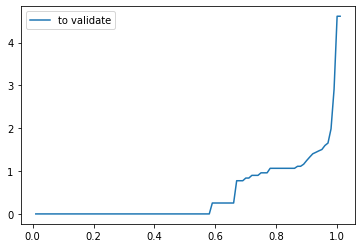

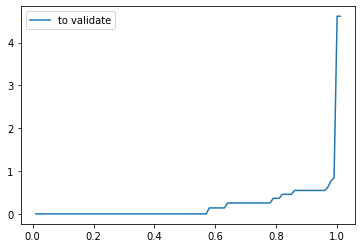

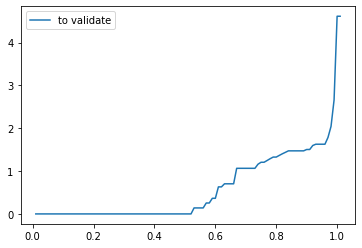

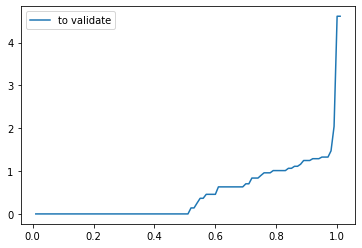

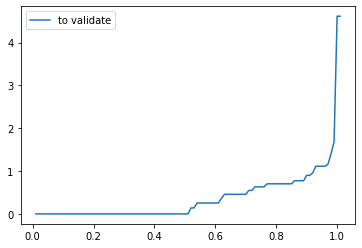

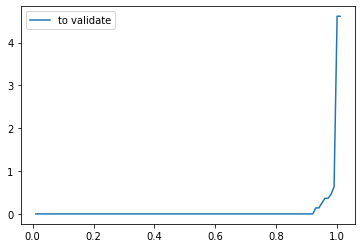

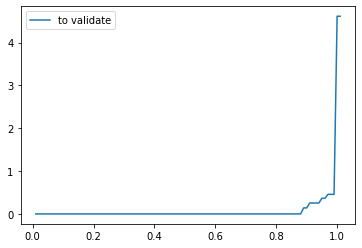

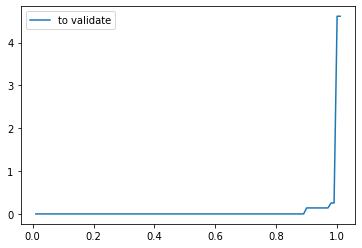

fail on  Investment_restriction


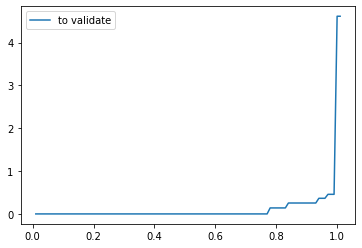

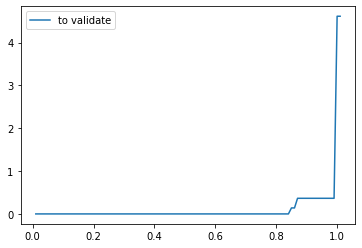

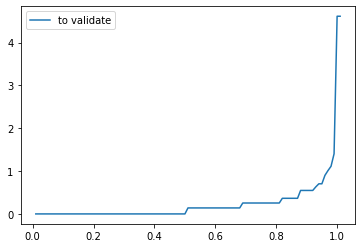

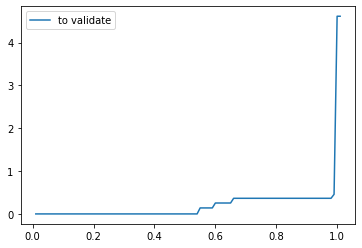

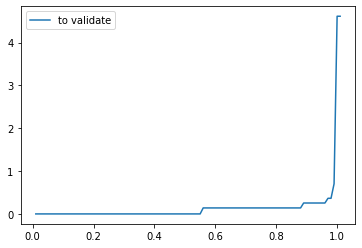

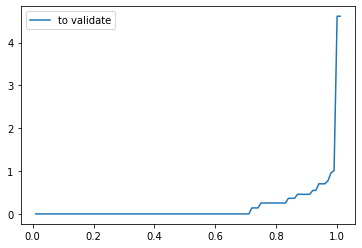

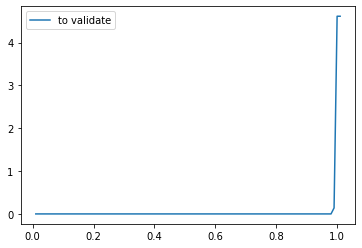

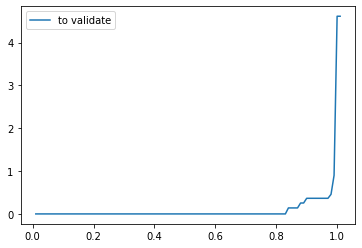

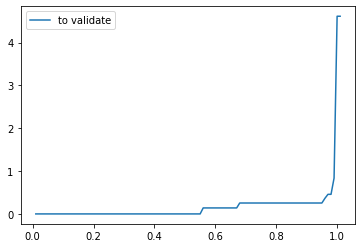

In [24]:
for index, model_name in enumerate(models):
    try:
        
        ds = datasets[model_name]['df_validation']

        to_validate, confidences = get_plot_confidence_and_validate_points(ds)

        plt.plot(confidences, np.log(to_validate + 1), label = "to validate")
        plt.legend()
        plt.show()
    except:
        print('fail on ', model_name)

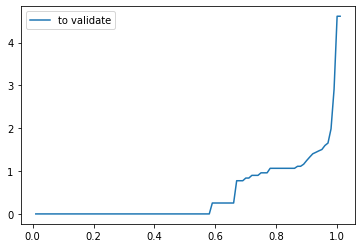

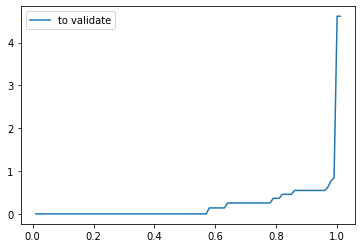

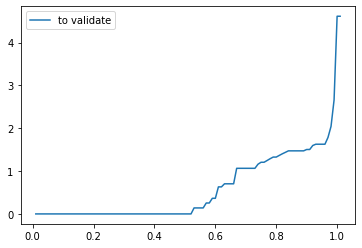

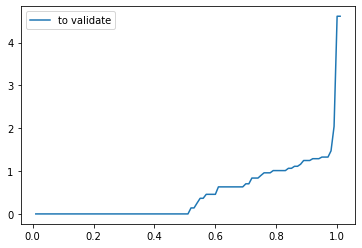

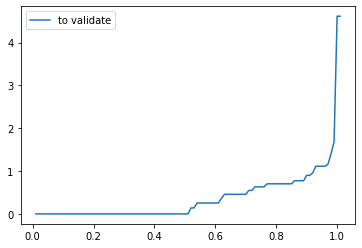

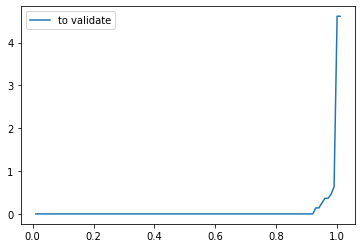

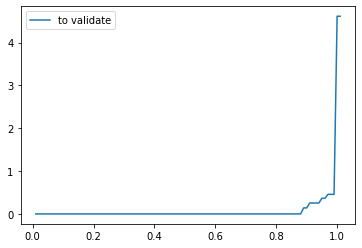

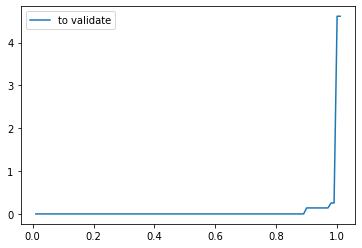

fail on  Investment_restriction


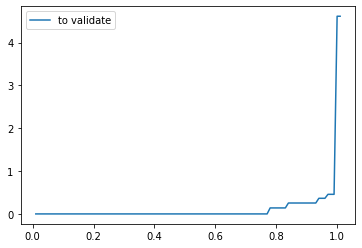

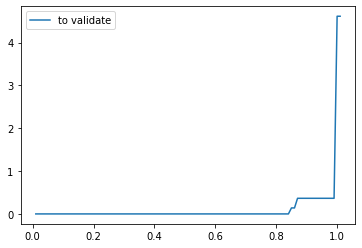

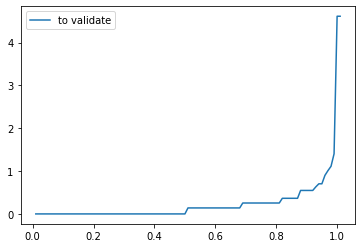

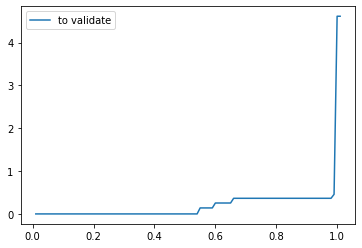

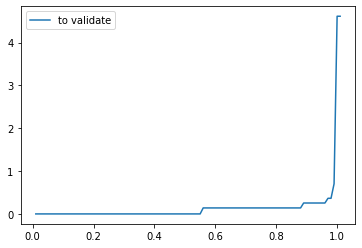

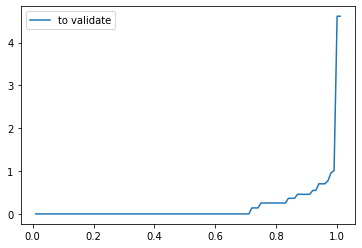

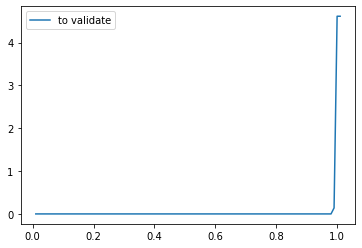

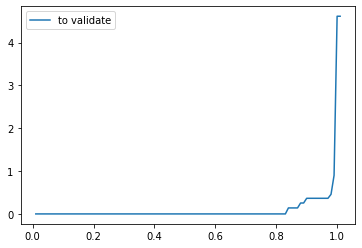

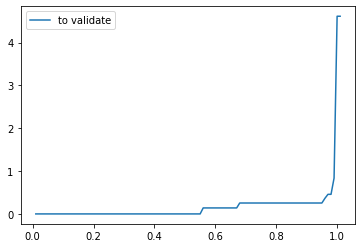

In [25]:
for index, model_name in enumerate(models):
    try:
        ds = datasets[model_name]['df_validation']

        to_validate, confidences = get_plot_confidence_and_validate_points(ds)

        plt.plot(confidences, np.log(to_validate + 1), label = "to validate")
        plt.legend()
        plt.show()
    except:
        print('fail on ', model_name)

In [50]:
from sklearn.metrics import log_loss
confidence_level = 0.9
for model_name in models:
    try:
        with open(('./models\\CLASS_PROSPECTUS_%s_CountVectorizer.rft' % model_name), 'rb') as f:
            model = pickle.load(f)
        with open(('./models\\VECTOR_PROSPECTUS_%s_CountVectorizer.txt' % model_name), 'rb') as f:
            vector = pickle.load(f)  

        ds = datasets[model_name]['df_validation']
        ds['target'] = ds.apply(lambda r: 'empty' if r['target']==None else r['target'], axis=1)
        stupid_predict_prob = [sum(ds["target"]) / len(ds["target"])] * len(ds["target"])
        ds['predict']= model.predict(vector.transform(ds['x']))
        predict_prob = [elem for elem in model.predict_proba(vector.transform(ds['x']))]

        ds['confidence']=np.transpose(np.amax(model.predict_proba(vector.transform(ds['x'])), axis=1))

        precision = round(100- 100*len(ds[(ds['confidence']>=confidence_level)&(ds['target']!=ds['predict'])])/len(ds),2)
        to_validate = round(100*len(ds[(ds['confidence']<confidence_level)])/len(ds),2)
        try:
            print(f"log_loss = {log_loss(ds['target'], predict_prob)}, stupid_log_loss = {log_loss(ds['target'], stupid_predict_prob)}")
        except:
            pass

        try:
            first, second = (confusion_matrix(ds["target"], ds["predict"]))
        except:
            print(model_name)
            pass
        tn, fn = first
        fp, tp = second
        print(tn, fn, fp, tp)
        stats_df.loc[model_name,"log_loss_vectorizer"] = log_loss(ds['target'], predict_prob)
        stats_df.loc[model_name,"true_neg_vectorizer"] = tn
        stats_df.loc[model_name,"true_pos_vectorizer"] = tp
        stats_df.loc[model_name,"false_neg_vectorizer"] = fn
        stats_df.loc[model_name,"false_pos_vectorizer"] = fp

        print (f"Covenant ratio = {round(100*(tp + fn) / (fp + tn), 2)}, Model name = {model_name}, true_positive = {round(100 * tp / (tp + fn), 2)}, true_negative = {round(100 * tn / (tn + fp), 2)}")

        #print('Model %s statistic (validation rows %s): Precision= %s ; To_Validate=%s  at Confidence=%s' % (model_name, len(ds), precision, to_validate, confidence_level))
    except:
        print("fatal err ", model_name)

log_loss = 0.017531594911800324, stupid_log_loss = 0.06997133373511628
676 0 4 5
Covenant ratio = 0.74, Model name = Restriction_on_the_provision_of_collateral, true_positive = 100.0, true_negative = 99.41
log_loss = 0.05745626495160606, stupid_log_loss = 0.050218396761899785
679 0 2 4
Covenant ratio = 0.59, Model name = Change_of_control, true_positive = 100.0, true_negative = 99.71
log_loss = 0.0886188090730658, stupid_log_loss = 0.1370183733796794
662 2 14 7
Covenant ratio = 1.33, Model name = Cases_of_default, true_positive = 77.78, true_negative = 97.93
log_loss = 0.021460195163591003, stupid_log_loss = 0.0997387017328646
671 0 4 10
Covenant ratio = 1.48, Model name = Cross-default, true_positive = 100.0, true_negative = 99.41
log_loss = 0.011421985273911119, stupid_log_loss = 0.11083350135474888
669 0 2 14
Covenant ratio = 2.09, Model name = Collective_action_clauses, true_positive = 100.0, true_negative = 99.7
log_loss = 0.011319539853790962, stupid_log_loss = 0.0358551770471924

/home/delanary/.local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in long_scalars


log_loss = 0.052320631405428364, stupid_log_loss = 0.02815451196259687
682 0 1 2
Covenant ratio = 0.29, Model name = Limitation_on_payments, true_positive = 100.0, true_negative = 99.85
Investment_restriction
682 0 1 2
fatal err  Investment_restriction
log_loss = 0.0028301049627466545, stupid_log_loss = 0.010990786212846474
684 0 0 1
Covenant ratio = 0.15, Model name = Limitation_on_payments_to_subsidiaries, true_positive = 100.0, true_negative = 100.0
log_loss = 0.005654687009249705, stupid_log_loss = 0.02815451196259687
682 0 3 0
Covenant ratio = 0.0, Model name = Restriction_on_transactions_with_affiliates, true_positive = nan, true_negative = 99.56


/home/delanary/.local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in long_scalars


log_loss = 0.014203171297641412, stupid_log_loss = 0.04318483487846742
680 0 5 0
Covenant ratio = 0.0, Model name = Restriction_of_activity, true_positive = nan, true_negative = 99.27


/home/delanary/.local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in long_scalars


log_loss = 0.004958540791997078, stupid_log_loss = 0.02815451196259687
682 0 2 1
Covenant ratio = 0.15, Model name = Restriction_on_asset_sales, true_positive = 100.0, true_negative = 99.71
log_loss = 0.002838838034397779, stupid_log_loss = 0.01995565074694132
683 0 1 1
Covenant ratio = 0.15, Model name = Restriction_on_the_sale_of_assets_with_leaseback, true_positive = 100.0, true_negative = 99.85
log_loss = 0.008863371994404576, stupid_log_loss = 0.050218396761899785
679 0 2 4
Covenant ratio = 0.59, Model name = Limitation_on_merger, true_positive = 100.0, true_negative = 99.71
Restriction_on_the_layering_of_debt_obligations_by_rank
679 0 2 4
fatal err  Restriction_on_the_layering_of_debt_obligations_by_rank
log_loss = 0.005115484756329669, stupid_log_loss = 0.019955650746941323
683 0 2 0
Covenant ratio = 0.0, Model name = A_condition_of_suspension_of_the_covenants, true_positive = nan, true_negative = 99.71


/home/delanary/.local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in long_scalars


log_loss = 0.00413269394951629, stupid_log_loss = 0.010990786212846477
684 0 1 0
Covenant ratio = 0.0, Model name = Financial_covenants, true_positive = nan, true_negative = 99.85


/home/delanary/.local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in long_scalars


In [51]:
stats_df

,true_neg_vectorizer,true_pos_vectorizer,false_neg_vectorizer,false_pos_vectorizer,log_loss_vectorizer,true_neg_tf_idf,true_pos_tf_idf,false_neg_tf_idf,false_pos_tf_idf,log_loss_tf_idf
Restriction_on_the_provision_of_collateral,676,5,0,4,0.0175316,670,5,6,4,0.0287524
Change_of_control,679,4,0,2,0.0574563,679,4,0,2,0.0141878
Cases_of_default,662,7,2,14,0.0886188,656,9,8,12,0.0557721
Cross-default,671,10,0,4,0.0214602,671,12,0,2,0.0213839
Collective_action_clauses,669,14,0,2,0.011422,668,15,1,1,0.0089545
Limitation_on_indebtedness,681,1,0,3,0.0113195,681,2,0,2,0.0120282
Limitation_of_debt_of_subsidiaries,681,0,0,4,0.0121839,681,1,0,3,0.0182191
Limitation_on_payments,682,2,0,1,0.0523206,682,2,0,1,0.0108787
Investment_restriction,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Limitation_on_payments_to_subsidiaries,684,1,0,0,0.0028301,684,1,0,0,0.00216227
